# scmap for label transfer between our scRNAseq ref and snRNA from multiomics dualRNA-ATAC


In [40]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings
import anndata
warnings.filterwarnings('ignore')


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_sn/scmap/'
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


'/opt/conda/bin/python'

## Load data
### SC ref

In [41]:
sc_adataR = sc.read('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')

In [42]:
# Add cluster name and doublet information
clu_annot = pd.read_csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', header=0, index_col=0)
import collections 

if collections.Counter(sc_adataR.obs.index) == collections.Counter(clu_annot.index): 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 
    
vars2import = ['clusters_manual','louvain', 'is_doublet', 'scrublet_cluster_score', 'scrublet_score']
for var in vars2import:
    sc_adataR.obs[var] = clu_annot[var]

The lists are identical


In [43]:
sc_adataR.obs['clusters'] = sc_adataR.obs['clusters_manual']
sc_adataR.obs['clusters'].value_counts(dropna = False)

Mesenchymal_GATA2_NR2F1    77319
Supporting_female          57451
Mesenchymal_LHX9_ARX       51992
Sertoli                    37796
lowQC                      20815
Coel Epi                   12001
Germ cells                 11388
Endothelial                10948
Epithelial                  9679
PV                          7440
Erythroid                   7423
Doublets                    5639
Immune                      5157
Neural                      2530
Metanephros                 1503
Name: clusters, dtype: int64

In [44]:
# sc_adataR.var.index = [ i.decode("utf-8") for i in sc_adataR.var.index ]
# sc_adataR.raw.var.index = [ i.decode("utf-8") for i in sc_adataR.raw.var.index ]

# sc_adataR.obs.index = [ i.decode("utf-8") for i in sc_adataR.obs.index ]
# sc_adataR.obs['clusters'] = [ i.decode("utf-8") for i in sc_adataR.obs['clusters'] ]
# sc_adataR.obs['sex'] = [ i.decode("utf-8") for i in sc_adataR.obs['sex'] ]

In [45]:
sc_adataR = sc_adataR[[ 'female' not in i for i in sc_adataR.obs['sex'] ]]
sc_adataR = sc_adataR[[ i==12 for i in sc_adataR.obs['PCW'] ]]
sc_adataR = sc_adataR[[ 'Doublet' not in i for i in sc_adataR.obs['clusters'] ]]
sc_adataR = sc_adataR[[ 'Metanephros' not in i for i in sc_adataR.obs['clusters'] ]]
sc_adataR = sc_adataR[[ 'cycling' not in i for i in sc_adataR.obs['clusters'] ]]

In [46]:
supporting = pd.read_csv('/nfs/team292/lg18/with_valentina/supporting_nocycling_annotation.csv', index_col = 0)
print(supporting['annotated_clusters'].value_counts())
supporting = supporting[supporting['annotated_clusters'].isin(['sLGR5', 'Sertoli', 'sKITLG', 'Sertoli_WFDC2', 'coelEpi', 'sPAX8b', 'sPAX8m', 'FetalLeydig-like'])]
print(supporting['annotated_clusters'].value_counts())

Sertoli             19227
preGC_I_OSR1        11714
Sertoli_low          8763
preGC_II_hypoxia     8180
preGC_III            7871
preGC_II             6669
ovarianSurf          5148
coelEpi              4385
sLGR5                2660
preGC_III_Notch      2409
sPAX8b               1783
sPAX8m               1645
sKITLG               1245
Sertoli_WFDC2        1074
FetalLeydig-like      460
Name: annotated_clusters, dtype: int64
Sertoli             19227
coelEpi              4385
sLGR5                2660
sPAX8b               1783
sPAX8m               1645
sKITLG               1245
Sertoli_WFDC2        1074
FetalLeydig-like      460
Name: annotated_clusters, dtype: int64


In [47]:
stromal = pd.read_csv('/nfs/team292/lg18/with_valentina/mesenchymal_annotated.csv', index_col = 0)
print(stromal['annotated_clusters'].value_counts())
# stromal = stromal.replace({'annotated_clusters': ['M_HOXC6', 'M_SFRP2', 'M_cycling', 'MullDuctFib_LGR5', 'M_ALDH1A2', 'M_CRABP1_BMP4', 'M_ISL1_BMP4', 'M_CD24']}, 'M_mesonephros')
stromal = stromal[stromal['annotated_clusters'].isin(['M_MGP', 'M_ALX1', 'M_prog_ISL1',    'Gi',  'Ti', 'FetalLeydig'])]
print(stromal['annotated_clusters'].value_counts())

M_MGP               26162
Ti                  24745
M_cycling           16376
Gi                  14846
Oi                  11900
M_MullDuct_LGR5      6811
M_prog_ISL1          5021
M_ALX1               4625
M_MullDuct_AMHR2     3318
FetalLeydig          2368
Name: annotated_clusters, dtype: int64
M_MGP          26162
Ti             24745
Gi             14846
M_prog_ISL1     5021
M_ALX1          4625
FetalLeydig     2368
Name: annotated_clusters, dtype: int64


In [48]:
germcells = pd.read_csv('/nfs/team292/lg18/with_valentina/germcells_annotation.csv', index_col = 0)
print(germcells['annotated_clusters'].value_counts())

PGC                  2011
oogonia_meiosis      1852
oogonia_STRA8        1672
oocyte                919
PGC_mitotic           869
GC_mitotic            793
pre-spermatogonia     753
Name: annotated_clusters, dtype: int64


In [49]:
supporting_germ = supporting.append(germcells)
supporting_germ = supporting_germ.append(stromal)
mapping_dict = supporting_germ['annotated_clusters'].to_dict()
sc_adataR.obs['annotated_clusters'] = sc_adataR.obs_names.map(mapping_dict)
sc_adataR.obs['annotated_clusters'].value_counts(dropna = False)

Trying to set attribute `.obs` of view, copying.


NaN                  15857
Sertoli               3264
M_MGP                 3181
Ti                    1568
Gi                    1231
FetalLeydig            267
sPAX8m                 255
M_ALX1                 142
coelEpi                 95
Sertoli_WFDC2           85
PGC                     35
M_prog_ISL1             22
FetalLeydig-like        15
pre-spermatogonia        9
sPAX8b                   6
Name: annotated_clusters, dtype: int64

In [50]:
# Replace NaN with big clusters 
sc_adataR.obs['annotated_clusters'] = sc_adataR.obs['annotated_clusters'].fillna(sc_adataR.obs['clusters'])

# Remove 
sc_adataR = sc_adataR[[i not in ['Supporting_female', 'Mesenchymal_GATA2_NR2F1', 'Mesenchymal_LHX9_ARX', 'Coel Epi', 'Germ cells', 'Stromal', 'lowQC'] for i in sc_adataR.obs['annotated_clusters']]]
sc_adataR.shape
sc_adataR.obs['annotated_clusters'].value_counts(dropna = False)

Sertoli              10013
M_MGP                 3181
Ti                    1568
Erythroid             1565
Gi                    1231
Immune                 878
Endothelial            722
PV                     403
FetalLeydig            267
sPAX8m                 255
Epithelial             228
M_ALX1                 142
coelEpi                 95
Sertoli_WFDC2           85
Neural                  49
PGC                     35
M_prog_ISL1             22
FetalLeydig-like        15
pre-spermatogonia        9
sPAX8b                   6
Name: annotated_clusters, dtype: int64

### SN 

In [51]:
sn_adataR = sc.read('/nfs/team292/lg18/with_valentina/gonadsV1_freezed/dual_snRNAsnATAC_male_Hrv15.h5ad')
sn_adataR = sn_adataR[[i not in ['4', '6'] for i in sn_adataR.obs['leiden']]]
sn_adata = anndata.AnnData(X=sn_adataR.raw.X, var=sn_adataR.raw.var, obs=sn_adataR.obs, asview=False)

## Intersect genes

In [52]:
sc_genes = sc_adataR.var_names.to_list()
sn_genes = sn_adata.var_names.to_list()

common_genes = list(set(sc_adataR.var.index.values).intersection(sn_adata.var.index.values))
print('common genes: ', len(common_genes))
sn_adata = sn_adata[:,common_genes]
sc_adataR = sc_adataR[:,common_genes]
print(sn_adata.X.shape)
print(sc_adataR.X.shape)

common genes:  24378
(2521, 24378)
(20769, 24378)


## R2PY setup


In [53]:
import rpy2.rinterface_lib.callbacks
import logging

In [54]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [55]:
import anndata2ri
anndata2ri.activate()

In [56]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## scmap

In [57]:
%%R
library(Matrix)
library(scmap)

In [58]:
%%R -i sc_adataR
sc_adataR

class: SingleCellExperiment 
dim: 24378 20769 
metadata(0):
assays(1): X
rownames(24378): CASC9 JADRR ... CRAT FAM171B
rowData names(160): gene_ids.0 feature_types.0 ... n_cells.52 n_cells
colnames(20769): FCA_GND8810846_AAACGGGCAAACCCAT
  FCA_GND8810846_AAACGGGCAGCTTAAC ... FCA_GND9331966_TTTGTCATCGCTTAGA
  FCA_GND9331966_TTTGTCATCGGCATCG
colData names(23): X5v1.1 TP ... clusters_manual annotated_clusters
reducedDimNames(0):
altExpNames(0):


In [59]:
%%R -i sn_adata
rowData(sn_adata)$feature_symbol <- rownames(sn_adata)
sn_adata

class: SingleCellExperiment 
dim: 24378 2521 
metadata(0):
assays(1): X
rownames(24378): CASC9 JADRR ... CRAT FAM171B
rowData names(14): gene_ids.0 feature_types.0 ... n_cells
  feature_symbol
colnames(2521): HD_F_GON9525419_AAACAGCCACCTCAGG
  HD_F_GON9525419_AAACATGCAGGCTAGA ... HD_F_GON9525420_TTTGTGTTCGAAGTAG
  HD_F_GON9525420_TTTGTTGGTGAGCGAA
colData names(14): n_genes sample ... is_doublet leiden
reducedDimNames(0):
altExpNames(0):


In [60]:
%%R 

counts <- assay(sc_adataR, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(sc_adataR) <- log2(t(t(counts)/size.factors) + 1)
assayNames(sc_adataR)

[1] "X"         "logcounts"



FALSE  TRUE 
23978   400 


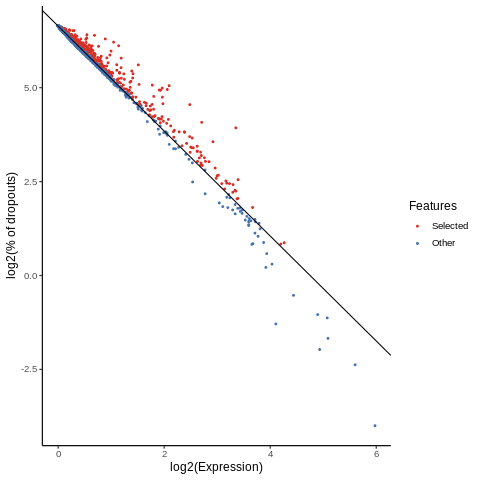

In [61]:
%%R

rowData(sc_adataR)$feature_symbol <- rownames(sc_adataR)
logcounts(sc_adataR) <- as.matrix(logcounts(sc_adataR))
sc_adataR <- selectFeatures(sc_adataR, n_features = 400, suppress_plot = FALSE)
print(table(rowData(sc_adataR)$scmap_features))

              M_MGP   Immune   Neural       Gi Erythroid       Ti    M_ALX1
A2M        0.000000 0.000000 0.000000 0.000000  0.000000 0.000000 0.0000000
ABRACL     0.000000 0.000000 0.000000 0.000000  0.000000 0.000000 0.0000000
AC022075.1 0.000000 0.000000 0.000000 0.000000  0.000000 0.000000 0.0000000
ACTA2      0.000000 0.000000 0.000000 0.000000  0.000000 0.000000 0.8889475
ACTG1      4.574228 3.295026 4.094387 4.316664  1.771126 4.320667 4.6325140
ADIPOR1    0.000000 0.000000 0.000000 0.000000  2.552409 0.000000 0.0000000
                 PV Endothelial   coelEpi FetalLeydig  Sertoli Epithelial
A2M        0.000000    1.485286 0.0000000    0.000000 0.000000   0.000000
ABRACL     0.000000    0.000000 0.4260406    0.000000 1.320808   0.000000
AC022075.1 0.000000    0.000000 0.0000000    0.000000 0.000000   0.000000
ACTA2      1.905224    0.000000 0.0000000    0.000000 0.000000   0.000000
ACTG1      4.356121    4.052142 4.2470185    3.633552 3.114665   3.650365
ADIPOR1    0.000000    0

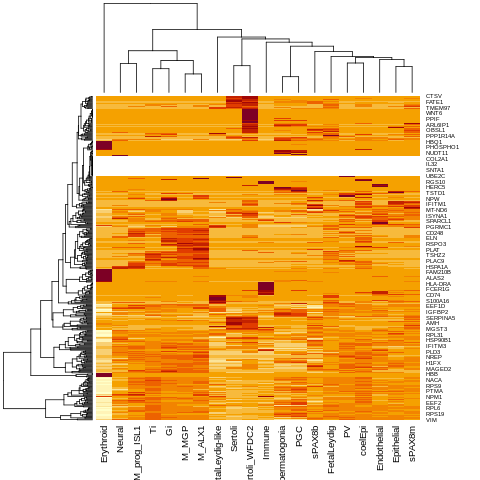

In [62]:
%%R 

sc_adataR <- indexCluster(sc_adataR, cluster_col = "annotated_clusters")
print(head(metadata(sc_adataR)$scmap_cluster_index))
heatmap(as.matrix(metadata(sc_adataR)$scmap_cluster_index))

In [63]:
%%R 

counts <- assay(sn_adata, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(sn_adata) <- log2(t(t(counts)/size.factors) + 1)
logcounts(sn_adata) <- as.matrix(logcounts(sn_adata))
assayNames(sn_adata)

[1] "X"         "logcounts"


In [64]:
%%R -o scmapCluster_results

scmapCluster_results <- scmapCluster(
  projection = sn_adata, threshold = 0.5,
  index_list = list(
    sc_adataR = metadata(sc_adataR)$scmap_cluster_index
  )
)

In [65]:
%%R 

print(head(scmapCluster_results$scmap_cluster_labs))
print(head(scmapCluster_results$scmap_cluster_siml))
print(head(scmapCluster_results$combined_labs))

     sc_adataR         
[1,] "FetalLeydig-like"
[2,] "Sertoli_WFDC2"   
[3,] "FetalLeydig-like"
[4,] "unassigned"      
[5,] "Sertoli_WFDC2"   
[6,] "unassigned"      
     sc_adataR
[1,] 0.6433125
[2,] 0.5314905
[3,] 0.6037263
[4,] 0.4832590
[5,] 0.6375481
[6,] 0.4415464
[1] "FetalLeydig-like" "Sertoli_WFDC2"    "FetalLeydig-like" "unassigned"      
[5] "Sertoli_WFDC2"    "unassigned"      


In [66]:
scmapCluster_results

scmap_cluster_labs,[RTYPES.STRSXP]
scmap_cluster_siml,[RTYPES.REALSXP]
combined_labs,[RTYPES.STRSXP]


In [67]:
labels = list(scmapCluster_results[0])
sn_adataR.obs['scmap_labels'] = labels
sn_adataR.obs['scmap_labels'].value_counts(dropna = False)

Trying to set attribute `.obs` of view, copying.


Sertoli_WFDC2        992
unassigned           306
FetalLeydig-like     302
M_ALX1               256
Ti                   243
FetalLeydig          159
M_prog_ISL1          110
Immune                34
PGC                   28
Gi                    26
pre-spermatogonia     23
sPAX8m                13
Neural                11
coelEpi               10
Endothelial            4
PV                     2
Sertoli                1
Epithelial             1
Name: scmap_labels, dtype: int64

In [68]:
similarities = scmapCluster_results[1]
similarities = [val for sublist in similarities for val in sublist]
#similarities
sn_adataR.obs['scmap_similarities'] = similarities

In [69]:
sn_adataR.obs[['scmap_labels', 'scmap_similarities']].to_csv('/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_male_Hrv15_scmap_predictions_highRes.csv')

... storing 'scmap_labels' as categorical


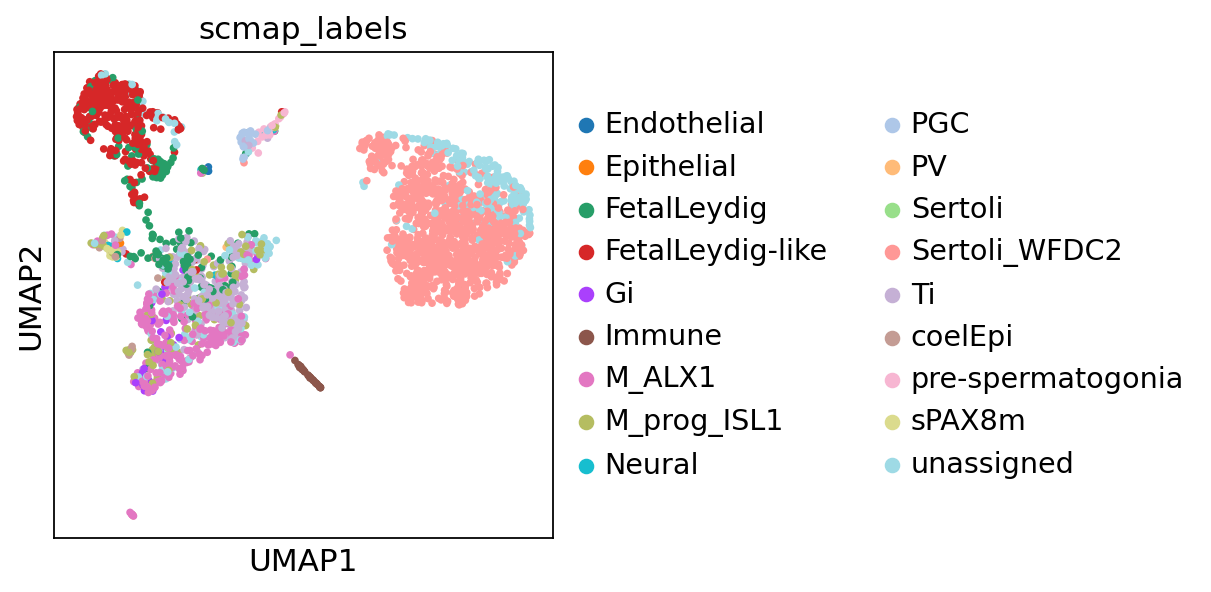

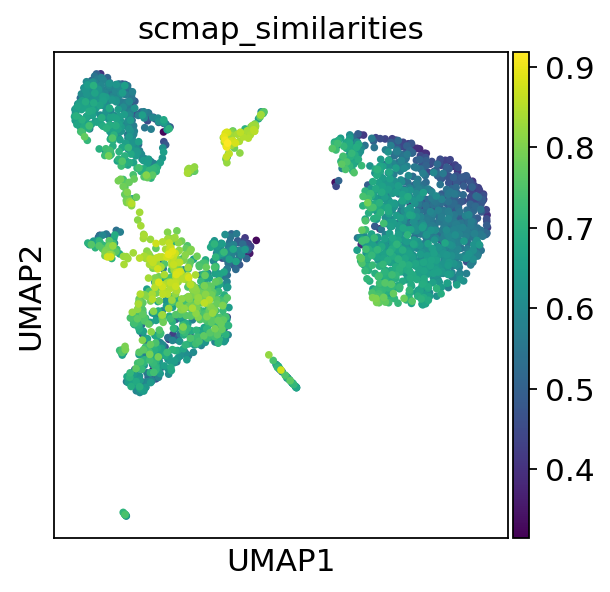

In [70]:
sc.pl.umap(sn_adataR, color='scmap_labels')
sc.pl.umap(sn_adataR, color='scmap_similarities')